# fork. greyscale-mobilenet-lb-0-892

## Setup
Import the necessary libraries and a few helper functions.

In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import ast
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
import random
import seaborn as sns
import cv2
import pandas as pd
import gc
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Activation,GlobalAveragePooling2D
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from keras.models import Sequential,Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from keras.applications import *
from keras.utils import to_categorical
from keras.applications.mobilenet import preprocess_input
from keras_tqdm import TQDMNotebookCallback
import json
start = dt.datetime.now()

C:\Anaconda3\envs\py35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
use_raw = True
if use_raw ==True:
    DP_DIR = './input/shuffle_raw_csvs_30k/'
else:
    DP_DIR = './input/shuffle_csvs_30k/'
INPUT_DIR = './input/'

BASE_SIZE = 256
NCSVS = 100
NCATS = 340
np.random.seed(seed=2031)#파일순서
tf.set_random_seed(seed=1987)

def f2cat(filename: str) -> str:
    return filename.split('.')[0]

def list_all_categories():
    files = os.listdir(os.path.join(INPUT_DIR, 'train_simplified'))
    return sorted([f2cat(f) for f in files], key=str.lower)

In [3]:
def apk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

# Build Model

In [4]:
ONE_EPOCH_IMGS = 6000000
nbbone = 5
backbones_str = ['MobileNet','ResNet50','Xception', 'DenseNet121','NASNetMobile','InceptionResNetV2']
backbones = [MobileNet, ResNet50,  Xception, DenseNet121, NASNetMobile, InceptionResNetV2]
bb_128max_batch = [256,128,128,128,256,180]
batchsize = bb_128max_batch[nbbone]
last_freeze_lnum = None
STEPS = ONE_EPOCH_IMGS//batchsize
EPOCHS = 16
size = 139
input_shape = (size,size,3)
last_drop = 0.3
valid_file_num = 66


model_name = backbones_str[nbbone] + '_is_' + str(input_shape) + '_bs_' + str(batchsize) + '_lf_' + str(last_freeze_lnum)
model_name += '_vf_' + str(valid_file_num) + '_ur_' + str(use_raw)
weight_name = model_name + '.h5'
best_save_model_file = 'weights/' + weight_name
is_restart = True

    
print(best_save_model_file)

callbacks = [EarlyStopping(monitor='val_loss',
                           patience=3,
                           verbose=1,
                           min_delta=0.00001,
                           mode='min'),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=2,
                               verbose=1,
                               min_delta=0.0001,
                               mode='min'),
             ModelCheckpoint(monitor='val_loss',save_weights_only=True,
                             filepath=best_save_model_file,
                             save_best_only=True,
                             mode='min') ,
             TQDMNotebookCallback(),          
             ]

weights/InceptionResNetV2_is_(139, 139, 3)_bs_180_lf_None_vf_66_ur_True.h5


In [5]:
def build_model(backbone= MobileNet, input_shape = input_shape, use_imagenet = 'imagenet', base_freeze=False, last_freeze_lnum=None):
    if input_shape[2]==1:
        use_imagenet = None
    else:
        use_imagenet = use_imagenet
    if backbone == MobileNet:
        alpha = 1.0
        base_model = backbone(input_shape=input_shape, alpha=1., weights=use_imagenet,include_top= False)#, classes=NCATS)
    else:
        base_model = backbone(input_shape=input_shape, weights=use_imagenet,include_top= False)#, classes=NCATS)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    if last_drop != 0.0:
        x = Dropout(last_drop)(x)
    predictions = Dense(NCATS, activation='softmax', name='lastfc')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    if base_freeze == True:
        for layer in base_model.layers:
            layer.trainable = False
    
    if last_freeze_lnum is not None:
         for i in range(len(model.layers)-last_freeze_lnum):
            model.layers[i].trainable = False
    model.compile(optimizer=Adam(lr=0.002), loss='categorical_crossentropy',
                  metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy]) 

    return model

In [6]:
model = build_model(backbone= backbones[nbbone], use_imagenet=None,input_shape = input_shape, last_freeze_lnum=last_freeze_lnum)
#model.summary()

## Training with Image Generator

In [7]:
def draw_cv2(raw_strokes, size=256, lw=6, time_color=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - 245*t/len(raw_strokes) if time_color else 255 ## 순서
            sx = stroke[0][i]
            sy = stroke[1][i]
            ex = stroke[0][i + 1]
            ey = stroke[1][i + 1]
            _ = cv2.line(img, (sx, sy), (ex, ey), color, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img
    
def draw_cv2_color(raw_strokes, size=256, lw=6, time_color=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE,3), np.uint8)
    for t, stroke in enumerate(raw_strokes):     
        inertia_x = 0
        inertia_y = 0
        for i in range(len(stroke[0]) - 1):
            #color = 255 - min(t, 10) * 13 if time_color else 255 ## 순서
            color = int(255 - 245*(float(t)/len(raw_strokes))) if time_color else 255 ## 순서 개선
            print(color)
            sx = stroke[0][i]
            sy = stroke[1][i]
            ex = stroke[0][i + 1]
            ey = stroke[1][i + 1]
            color_v =  (np.sqrt((sx-ex)*(sx-ex) + (sy-ey)*(sy-ey)) / np.sqrt(size*size)) * 255 ## 속력 (1~0)
            color_a = (np.sqrt((inertia_x-ex)*(inertia_x-ex) + (inertia_y-ey)*(inertia_y-ey)) / np.sqrt(size*size*4)) * 255 ## 가속력 (1~0)
            _ = cv2.line(img, (sx, sy), (ex, ey), (color,color_v,color_a), lw)
            inertia_x = 2*ex -sx
            inertia_y = 2*ey-sy
            
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img


## channel 순서, 속력, 가속력, 시작점 interval시간, 마지막 stroke 마지막 점 총 drawing시간
def draw_cv2_color_new(raw_strokes, size=256, lw=6, time_color=True, last_drop_r = 0.0):
    if use_raw ==False:
        return draw_cv2_color(raw_strokes, size=size, lw=lw, time_color=time_color)
    stx_min, sty_min = 99999, 99999
    stx_max, sty_max = 0,0
    #stt_se = 0  #처음 고민하는 시간 ?어떻게 반영? -> raw에도 없음. 0부터 시작됨.
    ett=0  # 얼마나 빨리 완료하는가 20초 이하 
    
    for t, stroke in enumerate(raw_strokes):
        if t == len(raw_strokes) -1:
            #print(stroke)
            ett = int(stroke[2][-1])
        for i in range(len(stroke[0])):
            stx_min = min(stx_min, int(stroke[0][i]))
            stx_max = max(stx_max, int(stroke[0][i]))
            sty_min = min(sty_min, int(stroke[1][i]))
            sty_max = max(sty_max, int(stroke[1][i]))
    
    limit_ett = 20*1000   
    ofs = 15
    
    if int(sty_max-sty_min+2*ofs) > 6000 or int(stx_max-stx_min+2*ofs)  > 6000:
        img = np.zeros((6000,6000,3), np.uint8)
    else:
        img = np.zeros((int(sty_max-sty_min+2*ofs), int(stx_max-stx_min+2*ofs),3), np.uint8)

        
    for t, stroke in enumerate(raw_strokes):     
        inertia_x = 0
        inertia_y = 0
        pre_st_t = 0 
        for i in range(len(stroke[0]) - 1):
            #color = 255 - min(t, 10) * 13 if time_color else 255 ## 순서
            color = int(255 - 245*float(t)/len(raw_strokes)) if time_color else 255 ## 순서 개선
            sx = int(stroke[0][i]) - stx_min +ofs
            sy = int(stroke[1][i]) - sty_min +ofs
            st = stroke[2][i]
            ex = int(stroke[0][i + 1])- stx_min +ofs
            ey = int(stroke[1][i + 1])- sty_min +ofs
            et = stroke[2][i+1]
            
            
            time = et-st
            if time ==0:
                time = 1
            
            color_v =  min(int((np.sqrt((sx-ex)*(sx-ex) + (sy-ey)*(sy-ey)) / time)*255.0), 255) ## 속력
            color_a = min(int((np.sqrt((inertia_x-ex)*(inertia_x-ex) + (inertia_y-ey)*(inertia_y-ey)) / np.sqrt(time*time))*255.0), 255) ## 가속력 (1~0)
            _ = cv2.line(img, (sx, sy), (ex, ey), (color,color_v,color_a), lw)
            
            if i==0:
                color_inter = int((float(et-pre_st_t)/limit_ett)*245)+10
                _ = cv2.circle(img, (sx, sy), lw, (0,0,color_inter), -1) ##interval time
            
            if i==len(stroke[0])-2 and t == len(raw_strokes) -1:
                color_end = int((float(ett)/(limit_ett)*245))+10

                _ = cv2.circle(img, (sx, sy), lw, (0,color_end,0), -1) ##end time
                
            inertia_x = 2*ex -sx
            inertia_y = 2*ey-sy
            pre_st_t=et
            
    return cv2.resize(img, (size, size)) #lw에 그림을 얼마나 크게 그렸는지 반영, 가로세로 비율도 반영됨

    
def image_generator_train(size, batchsize, vn, lw=6, time_color=True, channels=1):
    while True:
        for k in np.random.permutation(NCSVS):
            if k==vn:
                continue
            filename = os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(k))
            for df in pd.read_csv(filename, chunksize=batchsize):
                df['drawing'] = df['drawing'].apply(json.loads)
                
                x = np.zeros((len(df), size, size, channels))
                for i, raw_strokes in enumerate(df.drawing.values):
                    if channels ==1:
                        x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw,
                                                 time_color=time_color)
                    else:
                        x[i, :, :, ] = draw_cv2_color_new(raw_strokes, size=size, lw=lw,
                                                 time_color=time_color)                        
                x = preprocess_input(x).astype(np.float32)
                y = keras.utils.to_categorical(df.y, num_classes=NCATS)
                yield x, y

def image_generator_val(size, batchsize, vn, lw=6, time_color=True, channels=1):
    while True:
        filename = os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(vn))
        for df in pd.read_csv(filename, chunksize=batchsize):
            df['drawing'] = df['drawing'].apply(json.loads)
            x = np.zeros((len(df), size, size, channels))
            for i, raw_strokes in enumerate(df.drawing.values):
                if channels ==1:
                    x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw,
                                             time_color=time_color)
                else:
                    x[i, :, :, ] = draw_cv2_color_new(raw_strokes, size=size, lw=lw,
                                             time_color=time_color)                        
            x = preprocess_input(x).astype(np.float32)
            y = keras.utils.to_categorical(df.y, num_classes=NCATS)
            yield x, y                
                
def df_to_image_array_xd(df, size, lw=6, time_color=True, channels=1):
    df['drawing'] = df['drawing'].apply(json.loads)
    x = np.zeros((len(df), size, size, channels))
    for i, raw_strokes in enumerate(df.drawing.values):
        if channels ==1:
            x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw,
                                     time_color=time_color)
        else:
            x[i, :, :, ] = draw_cv2_color_new(raw_strokes, size=size, lw=lw,
                                     time_color=time_color)   
    x = preprocess_input(x).astype(np.float32)
    return x

,countrycode,drawing,recognized,timestamp,word,y,cv
0,CA,"[[[464, 471, 477, 485, 490, 496, 502, 507, 513...",True,2017-03-02 01:58:43.419520,envelope,103,0
1,AR,"[[[397, 403, 409, 410, 409, 408, 407, 406, 405...",True,2017-04-02 15:20:57.135890,horse,146,0
2,US,"[[[639, 644, 650, 656, 663, 670, 677, 682, 687...",True,2017-03-10 16:30:11.535640,waterslide,330,0
3,VN,"[[[120, 125, 130, 135, 140, 147, 154, 163, 168...",False,2017-03-07 10:23:29.720240,sandwich,244,0
4,US,"[[[985, 987, 989, 990, 991, 993, 993, 993, 993...",True,2017-03-22 04:46:50.169780,penguin,215,0


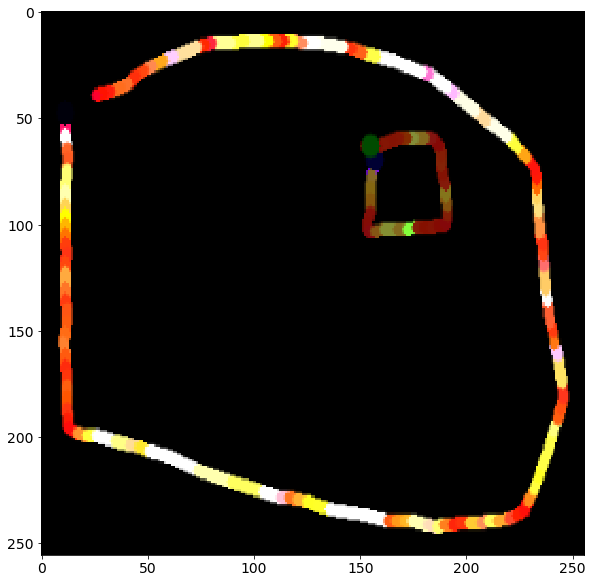

In [8]:
tt_df = pd.read_csv(os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(0)))
tt_df.head()


tt = json.loads(tt_df.drawing.values[17])
aimg = draw_cv2_color_new(tt)
plt.imshow(aimg)#, cmap='gray')
plt.show()

In [9]:

train_datagen = image_generator_train(size=size, batchsize=batchsize, vn=valid_file_num,channels=input_shape[2])
valid_datagen = image_generator_val(size=size, batchsize=batchsize, vn=valid_file_num,channels=input_shape[2])
filename = os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(valid_file_num))
v_df = pd.read_csv(filename)
num_val = v_df.shape[0]
v_df=None
gc.collect()
print(num_val, batchsize)

1179

495969 180


In [10]:
if is_restart == True:
    model.load_weights(best_save_model_file)

model.load_weights('weights/InceptionResNetV2_is_(256, 256, 3)_bs_40_vf_0.h5')

In [ ]:
hists=[]
print('batchsize', batchsize, 'save path', best_save_model_file)
train_datagen = image_generator_train(size=size, batchsize=batchsize, vn=valid_file_num,channels=input_shape[2])
valid_datagen = image_generator_val(size=size, batchsize=batchsize, vn=valid_file_num,channels=input_shape[2])


batchsize 180 save path weights/InceptionResNetV2_is_(139, 139, 3)_bs_180_lf_None_vf_66_ur_True.h5


In [ ]:
hist = model.fit_generator( train_datagen, steps_per_epoch=STEPS, validation_data=valid_datagen
                           , validation_steps=num_val//batchsize,
                           epochs=EPOCHS, verbose=2,   callbacks = callbacks )
hists.append(hist)

A Jupyter Widget

Epoch 1/16


A Jupyter Widget

 - 25716s - loss: 0.8296 - categorical_crossentropy: 0.8296 - categorical_accuracy: 0.7846 - top_3_accuracy: 0.9181 - val_loss: 0.7283 - val_categorical_crossentropy: 0.7283 - val_categorical_accuracy: 0.8084 - val_top_3_accuracy: 0.9310
Epoch 2/16


A Jupyter Widget

 - 25193s - loss: 0.7406 - categorical_crossentropy: 0.7406 - categorical_accuracy: 0.8073 - top_3_accuracy: 0.9292 - val_loss: 0.7351 - val_categorical_crossentropy: 0.7351 - val_categorical_accuracy: 0.8072 - val_top_3_accuracy: 0.9297
Epoch 3/16


A Jupyter Widget

 - 25366s - loss: 0.7196 - categorical_crossentropy: 0.7196 - categorical_accuracy: 0.8134 - top_3_accuracy: 0.9316 - val_loss: 0.8558 - val_categorical_crossentropy: 0.8558 - val_categorical_accuracy: 0.7755 - val_top_3_accuracy: 0.9162

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 4/16


A Jupyter Widget

 - 25389s - loss: 0.6226 - categorical_crossentropy: 0.6226 - categorical_accuracy: 0.8372 - top_3_accuracy: 0.9426 - val_loss: 0.5819 - val_categorical_crossentropy: 0.5819 - val_categorical_accuracy: 0.8458 - val_top_3_accuracy: 0.9474
Epoch 5/16


A Jupyter Widget

In [ ]:
hist = model.fit_generator( train_datagen, steps_per_epoch=STEPS, validation_data=valid_datagen
                           , validation_steps=num_val//batchsize,
                           epochs=EPOCHS, verbose=2,   callbacks = callbacks )
hists.append(hist)

In [ ]:
best_epoch = np.argmin(hist.history['val_loss']).astype(int)
best_top3_score = str(int(np.round(hist.history['val_top_3_accuracy'][best_epoch]*10000,0)))
num_timgs = str(ONE_EPOCH_IMGS*len(hist.epoch)//1000//1000)+'M'
sub_prefix = model_name+'_timgs_'+ num_timgs+'_localT3acc_'+best_top3_score
probs_file_path = './probs/' + sub_prefix+ '.npy'
sub_file_path = './subs/' + sub_prefix+ '.csv'
hist_file_path = './hists/' + sub_prefix + '.png'

In [ ]:
hist_df = pd.concat([pd.DataFrame(hist.history) for hist in hists], sort=True)
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_categorical_accuracy, lw=5, label='Validation Accuracy')
axs[0].plot(hist_df.categorical_accuracy, lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_categorical_crossentropy, lw=5, label='Validation MLogLoss')
axs[1].plot(hist_df.categorical_crossentropy, lw=5, label='Training MLogLoss')
axs[1].set_ylabel('MLogLoss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
fig.savefig(hist_file_path, dpi=300)
plt.show();

## Create Submission

In [ ]:
test = pd.read_csv(os.path.join(INPUT_DIR, 'test_simplified.csv'))
test.head()
x_test = df_to_image_array_xd(test, size, channels=input_shape[2])
print(test.shape, x_test.shape)
print('Test array memory {:.2f} GB'.format(x_test.nbytes / 1024.**3 ))

In [ ]:
test_predictions = model.predict(x_test, batch_size=batchsize, verbose=1)
top3 = preds2catids(test_predictions)
cats = list_all_categories()
id2cat = {k: cat.replace(' ', '_') for k, cat in enumerate(cats)}
top3cats = top3.replace(id2cat)

np.save(probs_file_path,test_predictions)
test['word'] = top3cats['a'] + ' ' + top3cats['b'] + ' ' + top3cats['c']
submission = test[['key_id', 'word']]
submission.to_csv(sub_file_path, index=False)
submission.head()
submission.shape